# Image segmentation

suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level.

Image segmentation has many applications in **medical imaging**, **self-driving cars** and **satellite imaging** to name a few.


## dataset:
The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi et al. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

* Class 1 : Pixel belonging to the pet.
* Class 2 : Pixel bordering the pet.
* Class 3 : None of the above/ Surrounding pixel.

In [16]:
!pip install -U tfds-nightly

In [6]:
!git --version
!git clone https://github.com/tensorflow/examples.git

git version 1.8.3.1


Cloning into 'examples'...
remote: Enumerating objects: 24177, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 24177 (delta 70), reused 43 (delta 40), pack-reused 24032 (from 3)
Receiving objects: 100% (24177/24177), 44.23 MiB | 0 bytes/s, done.
Resolving deltas: 100% (13088/13088), done.
Checking out files: 100% (2902/2902), done.


In [11]:
!cd examples && pip install .

Processing /ix/djishnu/Zarifeh/ML_DL/LLMs/Image_Segmentation/examples
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1740530213.1035013487801766704493630329122678477949057363859-py3-none-any.whl size=301603 sha256=45e491268cc4b91f016b0d493f971df859497c3731c640d5ba07fb62af076b92
  Stored in directory: /tmp/pip-ephem-wheel-cache-44hqxfof/wheels/52/91/e1/c874efdb56aca0f4dc2d9975141cf200ac3dd20c305e43032d
Successfully built tensorflow-examples


In [12]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [13]:
#Download the Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
#The segmentation masks are included in version 3+.

2025-03-03 07:44:43.226259: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dataset oxford_iiit_pet downloaded and prepared to /ihome/djishnu/zah47/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [15]:
print(info.version)
print(info.citation)
print(info.features)
print(info.supervised_keys)
print(info.splits)

3.2.0
@InProceedings{parkhi12a,
  author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Jawahar, C.~V.",
  title        = "Cats and Dogs",
  booktitle    = "IEEE Conference on Computer Vision and Pattern Recognition",
  year         = "2012",
}
FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
('image', 'label')
{'train': <SplitInfo num_examples=3680, num_shards=4>, 'test': <SplitInfo num_examples=3669, num_shards=4>}


In [10]:
#standardization
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1 #convert cls number to {0, 1, 2}
  return input_image, input_mask

In [11]:
#Compiles a function into a callable TensorFlow graph.
@tf.function
#data augmentation
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  # data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [12]:
#transform for test data
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [19]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [20]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [21]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

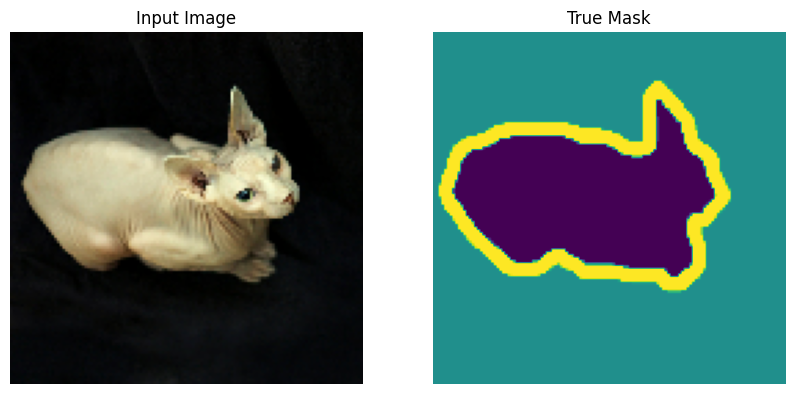

In [22]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Define the model
In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained MobileNetV2 model, whose outputs will be used, and the decoder will be the upsample block.

In [31]:
OUTPUT_CHANNELS = 3

In [33]:
from keras.applications import MobileNetV2
from keras import Model, layers, losses, utils
base_model = MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
down_stack.summary()

The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.



In [28]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [27]:
def unet_model(output_channels):
  inputs = layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = layers.Concatenate() # take an object
    x = concat([x, skip])

  # This is the last layer of the model
  last = layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return Model(inputs=inputs, outputs=x)

In [32]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 96),         1841984   ['input_2[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

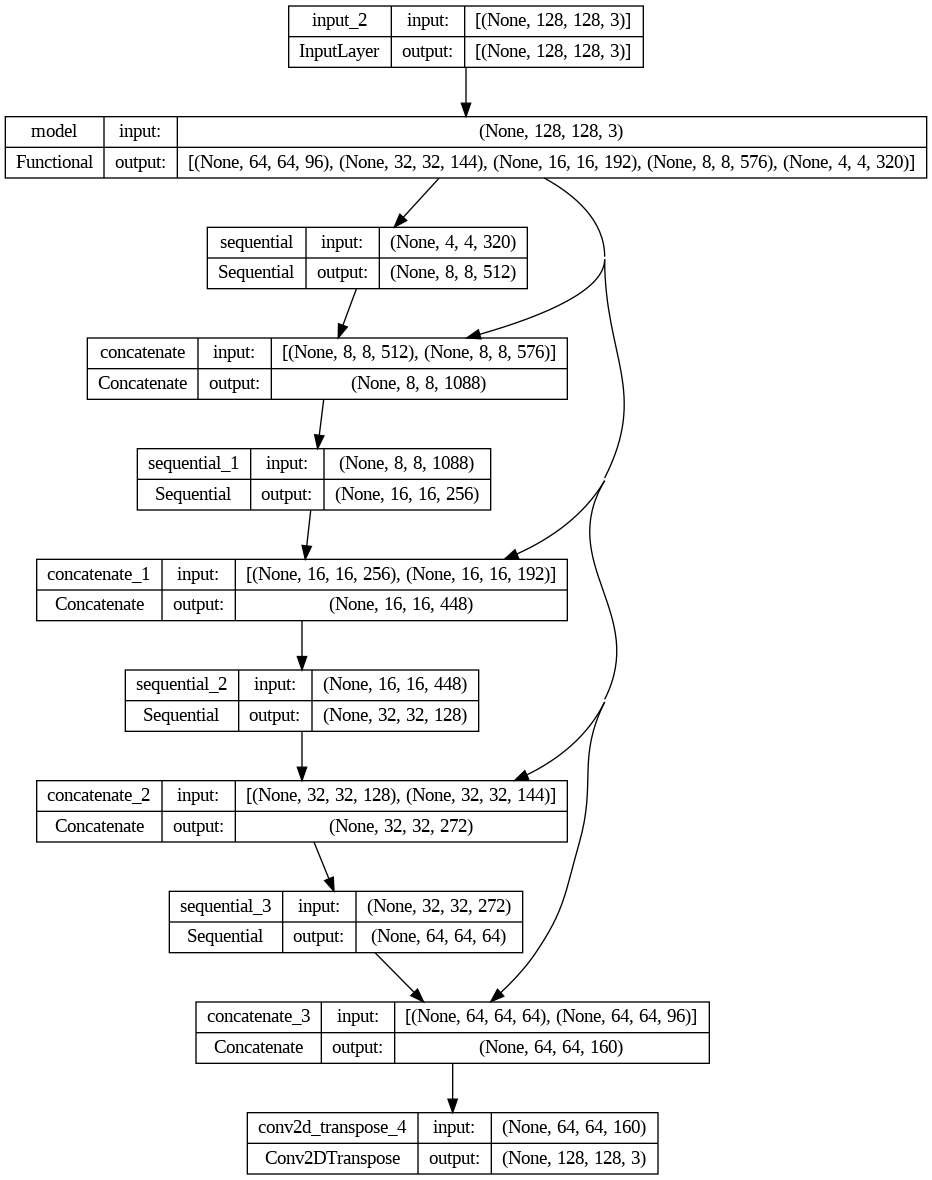

In [34]:
utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.



In [35]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [36]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 6s 6s/step


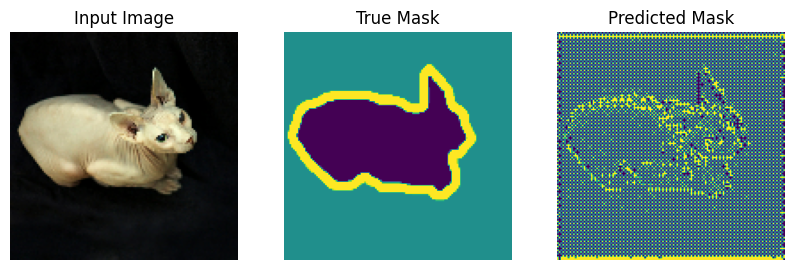

In [37]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below.



In [38]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 22ms/step


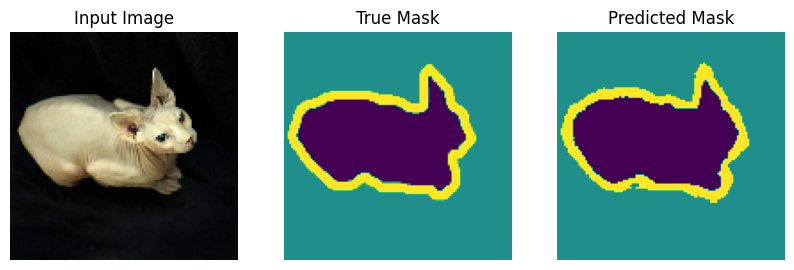


Sample Prediction after epoch 20

57/57 [==============================] - 10s 168ms/step - loss: 0.1376 - accuracy: 0.9373 - val_loss: 0.3206 - val_accuracy: 0.8913


In [39]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

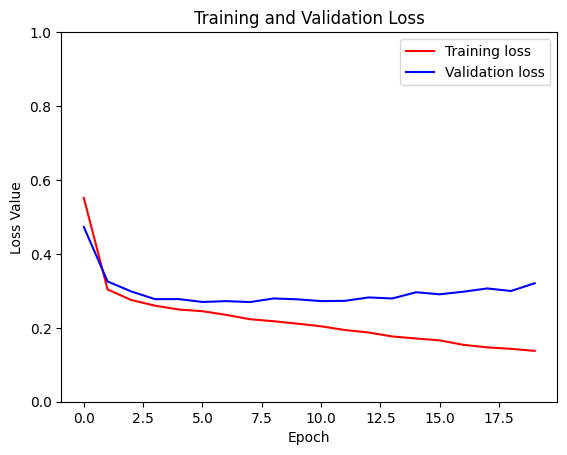

In [40]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Make predictions

2/2 [==============================] - 0s 43ms/step


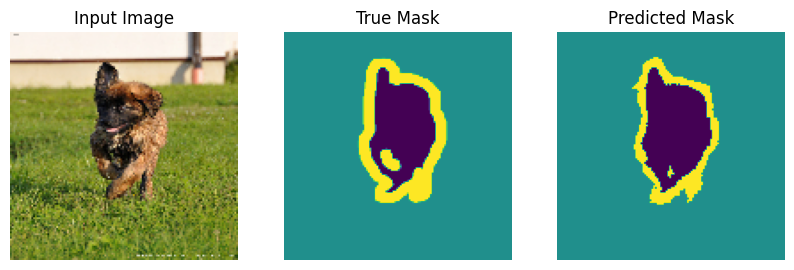

2/2 [==============================] - 0s 44ms/step


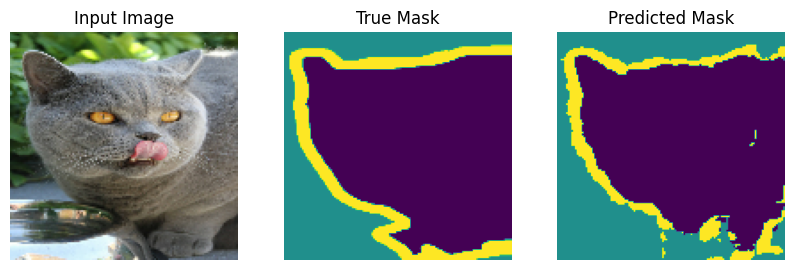

2/2 [==============================] - 0s 42ms/step


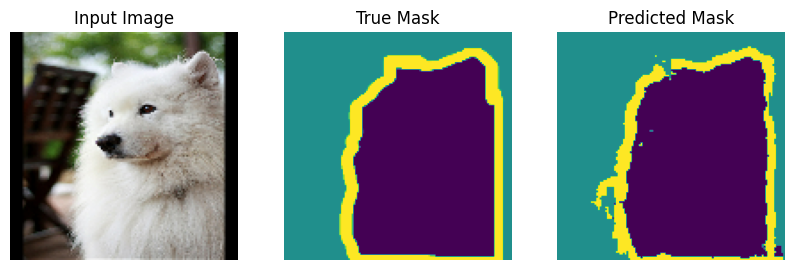

2/2 [==============================] - 0s 43ms/step


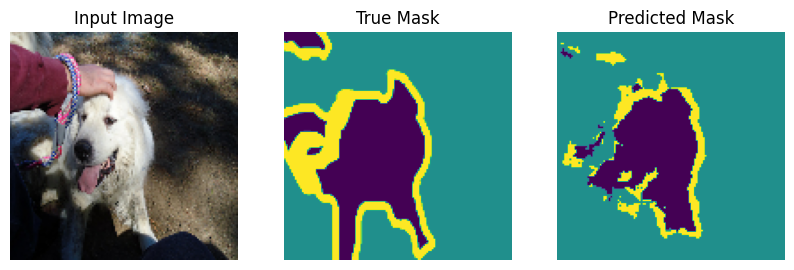

2/2 [==============================] - 0s 42ms/step


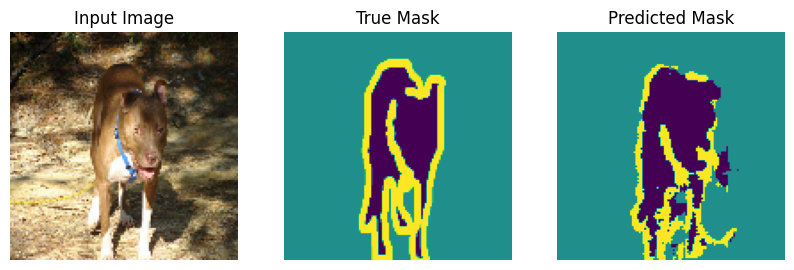

In [41]:
show_predictions(test_dataset, 5)